# Data Exploration


In [39]:
import polars as pl
data_test = pl.read_parquet(source="../../../data/test.parquet")

In [46]:
#ParquetFile and then this is returns a pyarrow Dataset
import pyarrow.dataset as ds
path_train_data = "../../../data/train.parquet"
data_train = ds.dataset(source=path_train_data, format="parquet")

In [47]:
data_train.head(num_rows=5)
example_row = data_train.head(num_rows=1)
print(example_row)           

pyarrow.Table
id: int64
buildingblock1_smiles: string
buildingblock2_smiles: string
buildingblock3_smiles: string
molecule_smiles: string
protein_name: string
binds: int64
----
id: [[0]]
buildingblock1_smiles: [["C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21"]]
buildingblock2_smiles: [["C#CCOc1ccc(CN)cc1.Cl"]]
buildingblock3_smiles: [["Br.Br.NCC1CCCN1c1cccnn1"]]
molecule_smiles: [["C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1"]]
protein_name: [["BRD4"]]
binds: [[0]]


In [48]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

In [49]:
def get_mol(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    return mol

In [50]:

def show_mol(smi, style="stick"):
    
    mol = get_mol(smi)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=500, height=500)
    view.addModel(mblock, "mol")
    view.setStyle({style: {}})
    view.zoomTo()
    view.show()
        

In [51]:

smi = example_row["buildingblock1_smiles"][0].as_py()
print(smi)
show_mol(smi)
        

C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [52]:
#Cleaning the smiles
smi = example_row["buildingblock2_smiles"][0].as_py()
print(smi)
show_mol(smi)  

C#CCOc1ccc(CN)cc1.Cl


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 01 Molecular Features

In [63]:

def clean_smi(smi):

    # Remove [Dy] from smiles
    smi = smi.replace("[Dy]", "")

    # Convert SMILES to a RDKit molecule object
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    
    # Remove any salts or fragments
    mol = Chem.RemoveHs(mol)  # Remove explicit hydrogens
    fragments = Chem.GetMolFrags(mol, asMols=True)
    
    # Keep the largest fragment
    largest_fragment = max(fragments, default=mol, key=lambda m: m.GetNumAtoms())
    
    # Standardize the molecule
    AllChem.Compute2DCoords(largest_fragment)  # Compute 2D coordinates
    
    # Convert the molecule back to a canonical SMILES string
    cleaned_smiles = Chem.MolToSmiles(largest_fragment, canonical=True)
    return cleaned_smiles
        

In [64]:
smi = example_row["buildingblock2_smiles"][0].as_py()
print(f"Original: {smi}")
smi = clean_smi(smi)
print(f"Cleaned:  {smi}")
show_mol(smi)
        

Original: C#CCOc1ccc(CN)cc1.Cl
Cleaned:  C#CCOc1ccc(CN)cc1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [65]:
smi = example_row["buildingblock3_smiles"][0].as_py()
print(f"Original: {smi}")
smi = clean_smi(smi)
print(f"Cleaned:  {smi}")
show_mol(smi)
        

Original: Br.Br.NCC1CCCN1c1cccnn1
Cleaned:  NCC1CCCN1c1cccnn1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [66]:
#Querying data
import pyarrow.compute as pc
condition = (pc.field("binds") == 1)
query = data_train.scanner(filter=condition)
        

In [67]:
example_row_binds = query.head(num_rows=1)
print(example_row_binds)
        

pyarrow.Table
id: int64
buildingblock1_smiles: string
buildingblock2_smiles: string
buildingblock3_smiles: string
molecule_smiles: string
protein_name: string
binds: int64
----
id: [[466]]
buildingblock1_smiles: [["C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21"]]
buildingblock2_smiles: [["C#CCOc1ccc(CN)cc1.Cl"]]
buildingblock3_smiles: [["Cc1cc2cc(CN)ccc2[nH]1"]]
molecule_smiles: [["C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1"]]
protein_name: [["HSA"]]
binds: [[1]]


In [68]:
smi = example_row_binds["molecule_smiles"][0].as_py()
print(f"Original: {smi}")
smi = clean_smi(smi)
print(f"Cleaned:  {smi}")
show_mol(smi)      

Original: C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1
Cleaned:  C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C@@H](CC#C)CC(N)=O)n2)cc1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [71]:
#Binding
no_bind_scanner = data_train.scanner(filter=(pc.field("binds") == 0))
bind_scanner = data_train.scanner(filter=(pc.field("binds") == 1)) 

        

In [72]:
n_no_bind = 0
for batch in no_bind_scanner.to_batches():
    n_no_bind += batch.num_rows

n_bind = 0
for batch in bind_scanner.to_batches():
    n_bind += batch.num_rows

print("Total rows of")
print(f"   No binding: {n_no_bind}")
print(f"   Binding:    {n_bind}")

Total rows of
   No binding: 293656924
   Binding:    1589906


Matplotlib is building the font cache; this may take a moment.


Total observations: 295,246,830
No binding: 0.995
Binding:    0.005


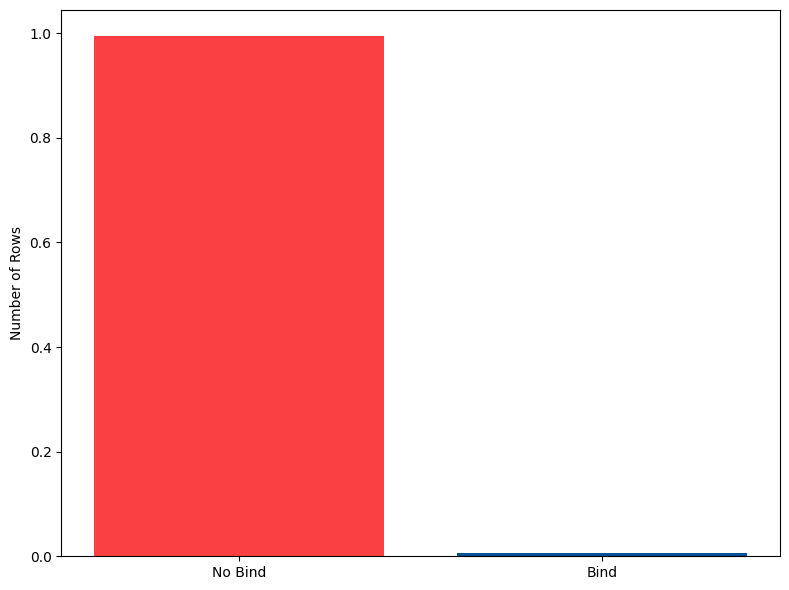

In [73]:

import matplotlib.pyplot as plt
labels = ['No Bind', 'Bind']
total = n_no_bind + n_bind
values = [n_no_bind/total, n_bind/total]

print(f"Total observations: {total:,}")
print(f"No binding: {values[0]:.3f}")
print(f"Binding:    {values[1]:.3f}")

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['#f94144', '#025099'])

# Add title and labels
plt.ylabel('Number of Rows')

# Show the plot
plt.tight_layout()
plt.show()
        

Target